In [1]:
import os
import argparse, sys
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import sys
syspath = 'SindyPendulum/'
if syspath not in sys.path:
    sys.path.append(syspath)
    
from sindy_library import SINDyLibrary
from autoencoder import Autoencoder, Encoder, Decoder

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

%load_ext autoreload
%autoreload 2


Using cpu device


In [2]:
#load Data

x = torch.tensor(np.load("x.npy"),dtype=torch.float)
xdot = torch.tensor(np.load("xdot.npy"),dtype=torch.float)

print(x.shape)
print(xdot.shape)

idx = 0
X = x[idx].reshape(100,-1).to(device)
Xdot = xdot[idx].reshape(100,-1).to(device)

print(X.shape)
print(Xdot.shape)

torch.Size([10, 100, 128, 128])
torch.Size([10, 100, 128, 128])
torch.Size([100, 16384])
torch.Size([100, 16384])


In [3]:
my_dataset = TensorDataset(X,Xdot)
val_size = round(X.shape[0] * 0.1)
train_size = X.shape[0] - val_size
train_size, val_size

(90, 10)

In [4]:
batch_size = 100
train_subset, val_subset = torch.utils.data.random_split(my_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(val_subset, shuffle=False, batch_size=batch_size)

# Network




In [5]:
input_size = X.shape[1]
latent_dim = 2

In [6]:
model = Autoencoder(input_size,latent_dim).to(device)

In [7]:
model.SINDyLibrary.number_candidate_functions

2

In [8]:
model.SINDyLibrary.get_feature_names()

['z0', 'z1']

# Parameters and Training


In [9]:
def sequential_threshold(t):
    if (t % seq_thres == 0 and t>1):
        model.XI_coefficient_mask = torch.abs(model.XI) > 0.1

In [10]:
def save_model(t):
    if SAVE == True:
        if t % saving_rate == 0 and t > 0:
            print('salvataggio a ',t,"epoche")
            f1 = path + 'model' + '_' + str(t) + 'epochs' + '.pt'
            torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.configure_optimizers().state_dict(),
            'loss': model.loss_function,
            'sindy_coefficients': model.XI,
            'coefficient_mask' : model.XI_coefficient_mask
            }, f1)
            
            XI = model.XI.cpu().detach().numpy()
            np.save(path + 'model' + '_' + str(t) + 'epochs' + '.npy',XI)


In [11]:
def print_model(t):
    f = open(path + 'model_equation' + '_' + str(t) + '.txt', 'w')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    for j in range(latent_dim):
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]
            if  abs(coeff) >= 0.1 and coeff != 0:
                #print(f"dz{j} = {coeff:.4f} {feature_list[i]}")
                f.write(f"dz{j} = {coeff:.6f} {feature_list[i]}\n")
    f.close()

In [12]:
#training step for one epoch
def train_step(loss_list):
        
    #queste serve per le loss di ogni batch
    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    model.train()
    for batch, (X,Xdot) in enumerate (train_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)

        # Backpropagation
        optimizer = model.configure_optimizers()
        loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        
        
    for key in loss_epoch.keys():
            loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))
            
    del loss_epoch,loss_dict,xtilde, xtildedot, z, zdot, zdot_hat,loss

In [13]:
def validation_step(loss_val_list):
    loss_val_epoch = []
    model.eval()     # Optional when not using Model Specific layer
    for batch, (X,Xdot) in enumerate (val_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)
        # validation loss 
        loss, _ = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss_val_epoch.append(loss.item())
        del  xtilde, xtildedot, z, zdot, zdot_hat,loss

    loss_val_list.append(sum(loss_val_epoch)/len(loss_val_epoch))

In [14]:
def print_loss(t):
    if t % loss_rate == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')

In [15]:
t = 1

In [16]:
VALIDATION = False
SAVE = True

epochs = 2000
path = 'model/'

seq_thres = 100   # numero epoche ogni quanto fare seq thres

equation_rate = 100 #print delle equazioni trovate

saving_rate = 100 # numero epoche in cui salvo il modello e gli XI

loss_rate = 50  #print delle loss


In [17]:
# loss_list = {}
# loss_list['recon_loss'] = []
# loss_list['sindy_loss_x'] = []
# loss_list['sindy_loss_z'] = []
# loss_list['sindy_regular_loss'] = []
# loss_list['tot'] = []
# loss_val_list = []


# while t <= epochs:
#     print("epoch:",t)
#     train_step(loss_list)
    
#     validation_step(loss_val_list)
    
#     print_loss(t)

#     save_model(t)
    
#     sequential_threshold(t)
    
#     if t % equation_rate == 0 and t>1:
#         print_model(t)
#         data = pd.DataFrame.from_dict(loss_list)
#         data.to_csv(path + 'data_'+str(t)+'epochs'+'.csv')
#     t = t + 1
# print("Done!")

In [18]:
# #plt.plot(loss_list['tot'])
# #plt.plot(loss_list['sindy_loss_z'])
# plt.plot(loss_list['sindy_loss_x'])

In [19]:
# list(model.named_parameters())

In [20]:
model

Autoencoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=16384, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=16384, bias=True)
  )
)

# LOAD models

In [21]:
# save_model(t)

In [22]:
path = '../model_1e5/' # con regolarizzatore a 1e-3 non avrá senso spero
#path = '../model_zero/' #con regolarizzatore a zero
#path = '../model_alphae6/'  # con regolarizzatore a 1e-6
t = 1600

In [23]:
# print(f"Caricato il checkpoint all'epoca:{t} ")
# model = Autoencoder(2601,10).to(device)
# optimizer = model.configure_optimizers()

# f1 = path + 'model' + '_' + str(t) + 'epochs' + '.pt'

# checkpoint = torch.load(f1)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [24]:
# print_model(1500)

In [25]:
# data = pd.DataFrame.from_dict(loss_list)
# data.to_csv('./data'+'_'+str(t)+'epochs'+'.csv')
# for key in loss_list.keys():
#     plt.plot(loss_list[key],label = key)
# plt.plot(loss_val_list,label = 'validation')    
# plt.legend(loc = 'best')
# plt.title('Loss con batch size di '+str(batch_size))

In [26]:
# import csv

# with open('./data'+'_'+str(t)+'epochs'+'.csv') as file:
#     reader = csv.DictReader(file)
#     for row in reader:
#         print(row)

In [27]:
model = Autoencoder(input_size,latent_dim).to(device)
optimizer = model.configure_optimizers()

t = '2000'
f1 = 'model/model' + '_' + str(t) + 'epochs' + '.pt'

checkpoint = torch.load(f1, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Compute dLoss/dLayer and Make Visualization

In [57]:
from functools import partial 

gradients = {}

def save_gradient(name, module, grad_in, grad_out):
    global gradients
    gradients[name] = grad_out

for name, module in model.named_modules():
    module.register_backward_hook(partial(save_gradient, name))

# idx = 7
# X = x[idx].reshape(100,-1).to(device)

# Xdot = xdot[idx].reshape(100,-1).to(device)
# xtilde, xtildedot, z, zdot, zdot_hat = model.forward(X,Xdot)

# loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
# loss.backward()


/Users/adampatni/anaconda3/envs/ml_hw1/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [70]:
import os
import imageio
from pathlib import Path

def gradient_to_images(grad, name, reshape_to, tmp_dir='./tmp/', cmap='viridis'):
    """
    Plot images from the gradients and save them sequentially.

    Args:
        grad (torch.Tensor): The gradients.
        directory (str): The directory to save images.
        name (str): Base name for the saved images.
        cmap (str): Color map for the images.
        n (int): Number of images in the batch.
    """

    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)

    grad = grad.cpu().numpy()
    n = grad.shape[0]
    grad_max = np.max(grad, axis=0).reshape(reshape_to)
    grad_min = np.min(grad, axis=0).reshape(reshape_to)
    
    for i in range(n):
        filename = os.path.join(tmp_dir, f"{name}_{i:04d}.png")

        grad_img = grad[i].reshape(reshape_to)
        grad_img = (grad_img - grad_min) / (grad_max - grad_min + 1e-5)
        
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(grad_img, cmap=cmap)
        ax.axis('off')
        
        # Save each frame with a sequential name
        plt.savefig(filename, dpi=100, bbox_inches='tight')
        plt.close()

def images_to_video(name, image_folder='./tmp/', output_directory='./viz/'):
    if not os.path.exists(image_folder):
        raise FileNotFoundError(f"image_folder: {image_folder} does not exist")

    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    image_paths = [os.path.join(image_folder, f"{name}_{i:04d}.png") 
              for i in range(100)
                if os.path.exists(os.path.join(image_folder, f"{name}_{i:04d}.png"))]
    video_path = Path(output_directory)/f"{name}.mp4"
    with imageio.get_writer(video_path, fps=5) as writer:
        for path in image_paths:
            image = imageio.imread(path)
            writer.append_data(image)
            os.remove(path)


In [71]:
global gradients

for idx in range(10):
    X = x[idx].reshape(100,-1).to(device)
    Xdot = xdot[idx].reshape(100,-1).to(device)
    xtilde, xtildedot, z, zdot, zdot_hat = model.forward(X,Xdot)
    gradients = {}
    loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
    loss.backward()


    for name, grad in gradients.items():
        print(name, grad[0].shape)
        grad_shape = grad[0].shape[1] 

        if grad_shape == 16384:  # This should be reshaped to [128, 128]
            reshape_to = (128,128)
        elif grad_shape == 128:  
            reshape_to = (16,8)
        elif grad_shape == 64:  
            reshape_to = (8,8)
        elif grad_shape == 32:  
            reshape_to = (8,4)
        else:
            continue
        gradient_to_images(grad[0], f"sim_{idx}_{name}", reshape_to=reshape_to)
        images_to_video(f"sim_{idx}_{name}", image_folder="./tmp/", output_directory='./viz/' )


decoder torch.Size([100, 16384])
100


/var/folders/l9/2q2ktn0j1cs_ss6nn5zrkdb80000gn/T/ipykernel_23790/977925591.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff61ac68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa628368000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fc9a8b5b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f9d88668000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fdf3505b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8591d5b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7c8c968000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa65e45b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7ba3968000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8240368000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd645a5b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff732268000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa6af85b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa2d425b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f93c6568000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff494c5b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7d61968000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb726a68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb03b95b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7a9bc68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7e26d5b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd75915b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fe9b3068000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f950ca5b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd12d568000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa335468000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8a0b15b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7faf01068000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fcfcfb5b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fc67545b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb066168000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd05da5b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fe162c68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8c16d68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f82a935b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f969ca68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8cbe35b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff2fba5b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd17b368000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb82cc5b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fe053968000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fbf4e868000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fac2f95b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8c87a68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f9b0f35b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7faa84b5b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f9841268000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb55615b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fbdfc968000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8791268000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd82b25b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb25f168000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fd43535b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fc64a95b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f9ee8a68000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fdc4635b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f9a83968000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8783168000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fe758b5b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f897b268000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7ea515b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa00725b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb784168000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fedd825b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f7e9d168000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fedef968000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fe7fa35b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff3e7b68000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fbc2a15b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f8706a5b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb13ca68000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb58315b000] Warning: data is not aligned! This can lead to a speed loss


decoder torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fb80a268000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc4 torch.Size([100, 16384])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff2ff168000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc3 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fcb1015b000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fc7c8168000] Warning: data is not aligned! This can lead to a speed loss


decoder.fc1 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa8be85b000] Warning: data is not aligned! This can lead to a speed loss


encoder torch.Size([100, 2])
encoder.fc4 torch.Size([100, 2])
encoder.fc3 torch.Size([100, 32])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7ff74a35b000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc2 torch.Size([100, 64])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (174, 174) to (176, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fe9a9168000] Warning: data is not aligned! This can lead to a speed loss


encoder.fc1 torch.Size([100, 128])
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (97, 174) to (112, 176) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7fa5e945b000] Warning: data is not aligned! This can lead to a speed loss


In [75]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.winter(np.linspace(0, 1, 100))  # You can replace 'plasma' with other colormaps like 'viridis', 'inferno', etc.


def video_plot_latent_gradients_for_batch(gradients, idx, layer_name="encoder.fc4", tmp_folder='./tmp/', output_dir="./viz" ):
    # Create a temporary folder to store the frames
    if not os.path.exists(tmp_folder):
        os.mkdir(tmp_folder)
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    # Extract the gradients for the specified layer
    latent_gradients = gradients[layer_name][0]

    assert latent_gradients.shape[1] == 2, "This function requires the latent dimension is 2"

    global_x_min = min([x.min() for x in latent_gradients[:, 0]])
    global_x_max = max([x.max() for x in latent_gradients[:, 0]])
    global_y_min = min([y.min() for y in latent_gradients[:, 1]])
    global_y_max = max([y.max() for y in latent_gradients[:, 1]])

    # print(latent_gradients.shape)

    # For each batch index, plot and save the scatter plot
    for i in range(latent_gradients.shape[0]):
        plt.figure(figsize=(5,5))
        plt.xlim(global_x_min, global_x_max)
        plt.ylim(global_y_min, global_y_max)
        plt.scatter(latent_gradients[i, 0].cpu().detach().numpy(), 
                    latent_gradients[i, 1].cpu().detach().numpy())
        plt.xlabel(r'$\frac{dL}{dz_1}$')
        plt.ylabel(r'$\frac{dL}{dz_2}$')
        plt.title(f'Gradients w.r.t Latent Space\nBatch Index: {i}')
        frame_path = os.path.join(tmp_folder, f"frame_{i:04d}.png")
        plt.savefig(frame_path)
        plt.close()

    # Read frames and convert them into a video
    frames = [imageio.imread(os.path.join(tmp_folder, f"frame_{i:04d}.png")) for i in range(latent_gradients.shape[0])]
    video_name = Path(output_dir)/f"sim_{idx}_{layer_name}_latent_gradients_evolution.mp4"
    imageio.mimwrite(video_name, frames, format='mp4', fps=20)

    # Cleanup: remove the temporary frames and directory
    for frame_file in os.listdir(tmp_folder):
        os.remove(os.path.join(tmp_folder, frame_file))
    os.rmdir(tmp_folder)

    print(f"Video saved as {video_name}")



layer_name = "encoder.fc4"  
# video_plot_latent_gradients_for_batch(gradients, tmp_folder='./tmp/', layer_name=layer_name)

global gradients

for idx in range(10):
    X = x[idx].reshape(100,-1).to(device)
    Xdot = xdot[idx].reshape(100,-1).to(device)
    xtilde, xtildedot, z, zdot, zdot_hat = model.forward(X,Xdot)
    gradients = {}
    loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
    loss.backward()
    
    # Generate a video of the evolution of loss-gradients in the latent space
    video_plot_latent_gradients_for_batch(gradients, idx, layer_name=layer_name, tmp_folder='./tmp/', output_dir='viz_latent_loss')

    # Show this evolution as a plot (color of point indicates evolution)
    latent_gradients = gradients['encoder.fc4'][0]
    plt.figure(figsize=(5,5))
    plt.scatter(latent_gradients[:, 0].cpu().detach().numpy(), latent_gradients[:, 1].cpu().detach().numpy(), c=colors)
    plt.xlabel(r'$\frac{dL}{dz_1}$')
    plt.ylabel(r'$\frac{dL}{dz_2}$')
    plt.title('Feature Importance in Latent Space')
    plt.colorbar(label='Time evolution of system')
    plt.savefig(Path('viz_latent_loss')/ f"sim_{idx}_{layer_name}_latent_gradients_evolution.jpg")
    plt.close()




/Users/adampatni/anaconda3/envs/ml_hw1/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/adampatni/anaconda3/envs/ml_hw1/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/Users/adampatni/anaconda3/envs/ml_hw1/lib/python3.10/site-packages/torch/

# Propagte basis vectors of latent space through Decoders

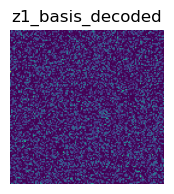

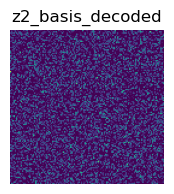

In [84]:
def tensor_to_image(tensor, plt_name):
    if tensor.shape[1] == 16384:
        reshape_to = (128, 128)
    else:
        return
    img = tensor.detach().numpy().reshape(reshape_to)

    norm_img = (img - img.min()) / (img.max() - img.min() + 1e-5)
    
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(norm_img)
    ax.axis('off')
    plt.title(plt_name)
    plt.show()

z1_basis = torch.tensor([[0.0, 1.0]]).cpu()
z2_basis = torch.tensor([[1.0, 0.0]]).cpu()

z1_basis_out = model.decoder(z1_basis)
z2_basis_out = model.decoder(z2_basis)


tensor_to_image(z1_basis_out, "z1_basis_decoded")
tensor_to_image(z2_basis_out, "z2_basis_decoded")